# Training Variational Autoencoder

## Overview

Since cross entropy loss (CE) 

In [1]:
import os
import torch
import numpy as np
import torch.nn as nn
import muse.supplier as spr
import muse.processor as pcr
import muse.model2 as mdl
import muse.trainer as trn
import muse.visualizer as vis

import warnings
warnings.filterwarnings("ignore")

## Data Preprocessing

1. Load and sort music by instruments
2. Remove 
3. Remove
4. Spliting into training and validation sets

In [2]:
### ===== Hyperparameters ===== ###

mdl_name1 = 'vae5_melody'
mdl_name2 = 'vae5_offset'
instrument = 'Piano'
filepath = "./../input/haydn/"
song_len = 200*1
stride = 200
epochs = 1000
learning_rate = 0.001
device = trn.get_device()

In [17]:
### ===== Data Preprocessing ===== ###

seed_load = np.random.randint(0,999999999)
seed_load = 592643464 # set to seed that works

all_midis, filenames = pcr.get_midis(filepath) # load all .midi files
Corpus, instru2corpus = pcr.extract_notes_batch(all_midis) # extract all notes and sort by instrument
Corpus = pcr.remove_rare(Corpus, 0)[0] # remove notes that occur for less than $thre$ times
Corpus, fmap, rmap = pcr.get_map(Corpus) # get forward-map and reverse-map from corpus
instru2corpus = pcr.remove_short(instru2corpus) # remove songs that are too short

X_train_melody, X_val_melody, X_train_offset, X_val_offset = pcr.train_test_split(instru2corpus, instrument, fmap, song_len, stride,\
                                                                                  seed=seed_load, process='center')
X_train_melody, X_val_melody = pcr.batchify(X_train_melody), pcr.batchify(X_val_melody) # reshape and turn into tensor
X_train_offset, X_val_offset = pcr.batchify(X_train_offset), pcr.batchify(X_val_offset) # reshape and turn into tensor

classes = len(set(Corpus)) # get number of unique keys

## Training the Melody



In [22]:
### ===== Training Loop ===== ###

def train_model(model, device, mdl_name,
                train_loader, val_loader, 
                lr, seeds, epochs, 
                eepoch=10, epoch_start=0,
                lda0=1, lda1=1, lda2=1,
                train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                stdlog=[],
                save=True, load=False):
    
    # get loss function 
    criterion1 = nn.MSELoss()
    criterion2 = nn.CrossEntropyLoss()
    
    # get optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # load model
    if load:
        model, train_losses, val_losses, train_acc, val_acc, epoch_start, seeds = trn.load_model(mdl_name, model, device)
        
    # set parameters
    if type(lda0) != np.ndarray: lda0 = np.ones(epochs)*lda0
    if type(lda1) != np.ndarray: lda1 = np.ones(epochs)*lda1
    if type(lda2) != np.ndarray: lda2 = np.ones(epochs)*lda2

    # training loop
    for epoch in range(epoch_start, epoch_start+epochs):
        
        # set std
        e = epoch-epoch_start
        if stdlog != []:
            model.std = stdlog[e]

        # train model
        model.train()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(train_loader):
            batch_data = batch_data.to(device)
            batch_data_noise = batch_data + torch.FloatTensor(*batch_data.shape).uniform_(-5,5) # add noise to data
            optimizer.zero_grad()
            recons, mu, logvar, prob = model(batch_data_noise)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            l.backward()
            optimizer.step()
            batch_losses.append(l.item())
            
        train_losses.append(np.mean(batch_losses))
        train_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))

        # validate model
        model.eval()
        
        batch_losses = []
        for batch_idx, batch_data in enumerate(val_loader):
            batch_data = batch_data.to(device)
            recons, mu, logvar, prob = model(batch_data)
            
            # calculate loss
            if lda1.all() != 0:
                l = lda0[e]*criterion1(recons, batch_data) + lda1[e]*criterion2(prob, batch_data.squeeze().long()) + lda2[e]*trn.KL(mu, logvar)
            else:
                l = lda0[e]*criterion1(recons, batch_data) + lda2[e]*trn.KL(mu, logvar)
            batch_losses.append(l.item())
            
        val_losses.append(np.mean(batch_losses))
        val_acc.append(trn.accuracy(recons.view(-1), batch_data.view(-1)))
        
        # print loss, accuracy
        if epoch % eepoch == 0:
            
            print('Epoch: {}\t TLoss: {:.6f}\t VLoss: {:.6f}\t TACC: {:.2f}\t VACC: {:.2f}'\
                  .format(epoch, train_losses[-1], val_losses[-1], train_acc[-1], val_acc[-1]))
   
        # save model
        if save:
            state = {'epoch': epoch, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
              'train_losses': train_losses, 'val_losses':val_losses, 
              'train_acc':train_acc, 'val_acc':val_acc, 'seeds': seeds}
            torch.save(state, './models/'+mdl_name+'.pt')
        
    return model, train_losses, val_losses, train_acc, val_acc

Epoch: 0	 TLoss: 370.187886	 VLoss: 234.202543	 TACC: 0.04	 VACC: 0.01
Epoch: 100	 TLoss: 54.883735	 VLoss: 57.290117	 TACC: 0.01	 VACC: 0.04
Epoch: 200	 TLoss: 52.551041	 VLoss: 54.579791	 TACC: 0.02	 VACC: 0.04
Epoch: 300	 TLoss: 50.134131	 VLoss: 52.719764	 TACC: 0.01	 VACC: 0.06
Epoch: 400	 TLoss: 516317.867558	 VLoss: 520259.521394	 TACC: 0.03	 VACC: 0.06
Epoch: 500	 TLoss: 211633.470751	 VLoss: 591785.973501	 TACC: 0.07	 VACC: 0.04
Epoch: 600	 TLoss: 176391.024018	 VLoss: 604170.984236	 TACC: 0.09	 VACC: 0.03
Epoch: 700	 TLoss: 153950.650195	 VLoss: 597872.362584	 TACC: 0.09	 VACC: 0.01
Epoch: 800	 TLoss: 201.150847	 VLoss: 212.374555	 TACC: 0.08	 VACC: 0.02
Epoch: 900	 TLoss: 49.013035	 VLoss: 67.413284	 TACC: 0.02	 VACC: 0.02
Epoch: 1000	 TLoss: 42.224709	 VLoss: 61.640911	 TACC: 0.06	 VACC: 0.03
Epoch: 1100	 TLoss: 42.638736	 VLoss: 64.104944	 TACC: 0.06	 VACC: 0.02
Epoch: 1200	 TLoss: 347572.977315	 VLoss: 534209.311857	 TACC: 0.01	 VACC: 0.06
Epoch: 1300	 TLoss: 132890.53121

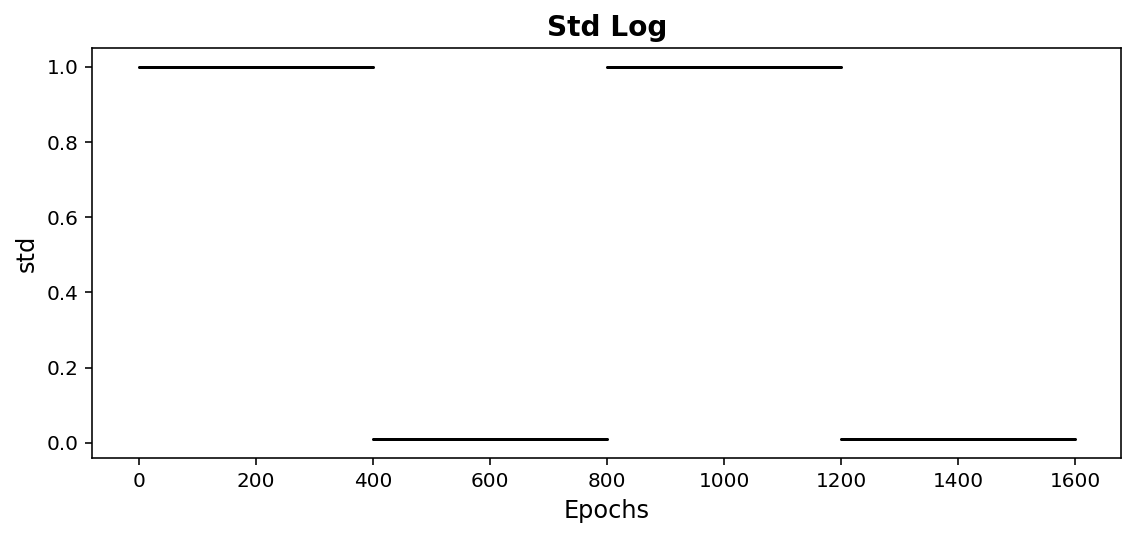

<Figure size 432x288 with 0 Axes>

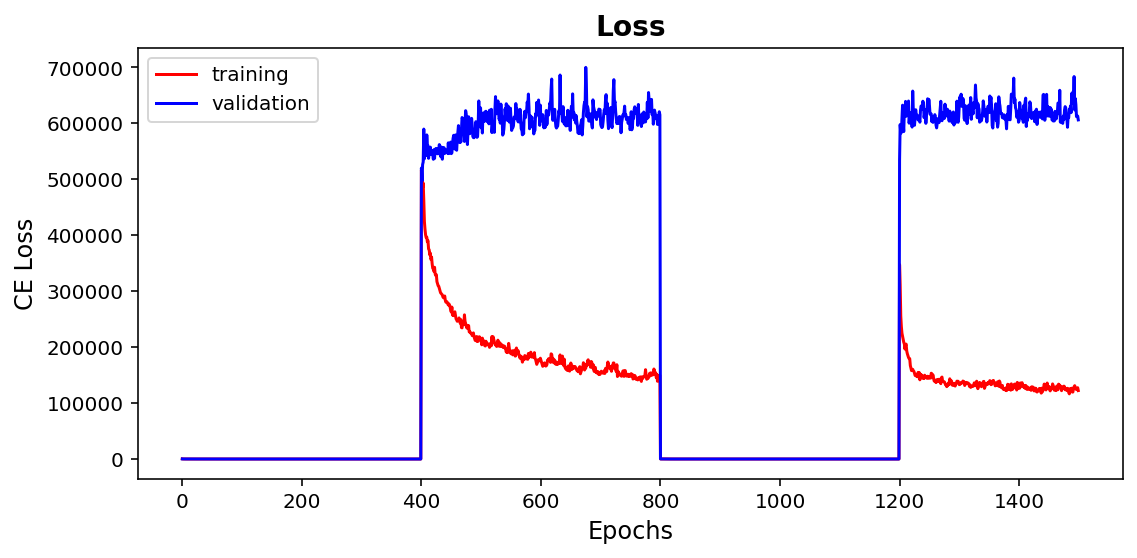

<Figure size 432x288 with 0 Axes>

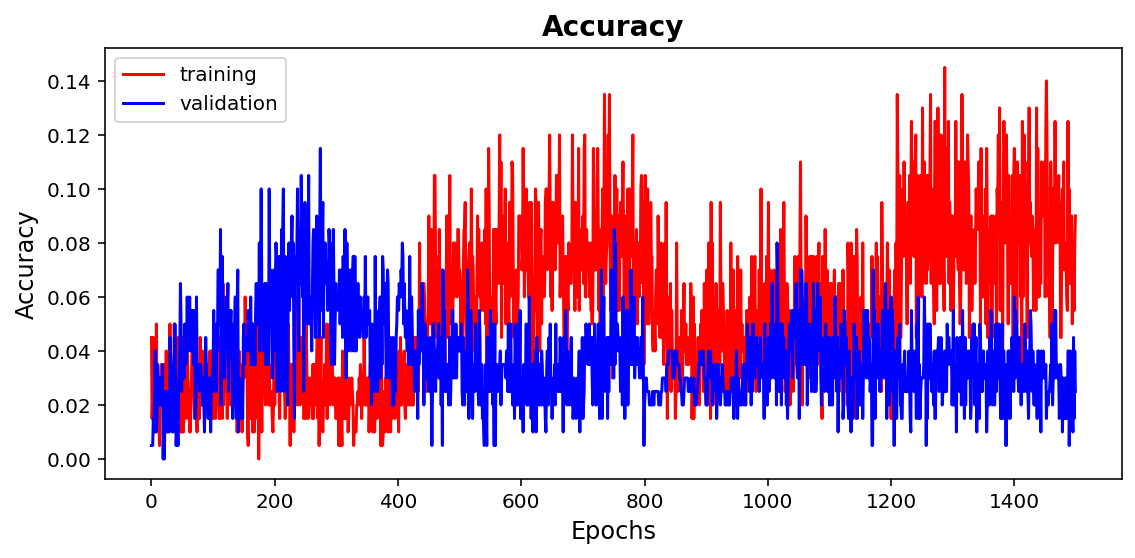

<Figure size 432x288 with 0 Axes>

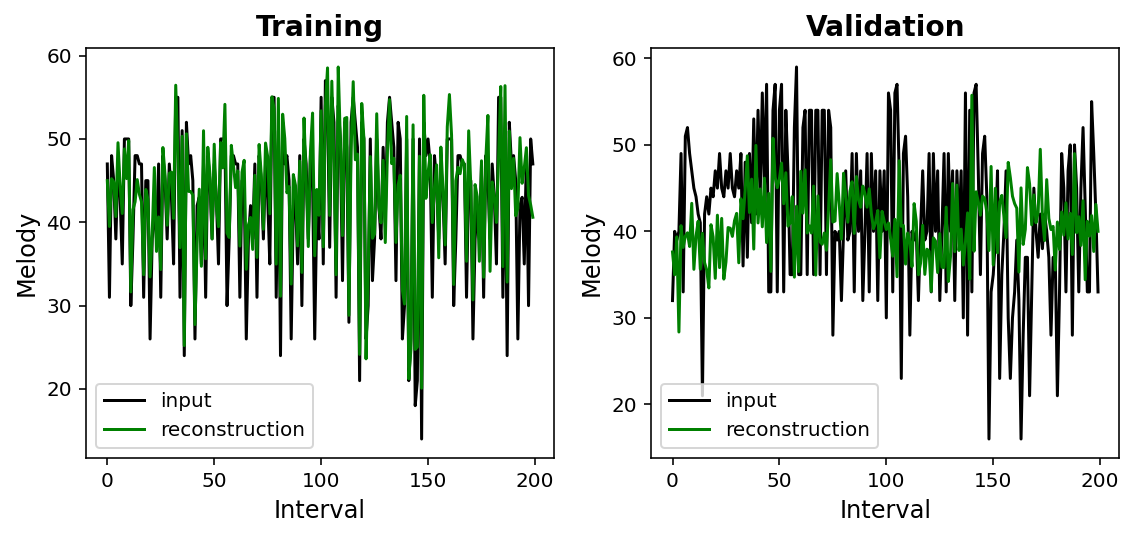

<Figure size 432x288 with 0 Axes>

In [32]:
### ===== Train Model for Melody using CELoss ===== ###

seed_model = np.random.randint(0,999999999)
seed_model = 527758681 
torch.manual_seed(seed_model)

model = mdl.cnn_varautoencoder(1, song_len//200, classes, std=1.0)
model.float()
model.to(device)

try: 
    stdlog = np.append(np.ones(400)*1, np.ones(400)*0.01)
    stdlog = np.append(stdlog, np.ones(400)*1)
    stdlog = np.append(stdlog, np.ones(400)*0.01)
    
    model_melody, train_losses_m, val_losses_m, train_acc_m, val_acc_m = train_model(model, device, mdl_name1+'_CE',
                   X_train_melody, X_val_melody,
                   learning_rate, [seed_load, seed_model], 1500,
                   eepoch=100,
                   lda0=0, lda1=1, lda2=1,
                   stdlog=stdlog,
                   train_losses=[], val_losses=[], train_acc=[], val_acc=[],
                   save=True, load=False)
    
    vis.plot_stdlog(stdlog, './figures/vae5_melody_CE_stdlog.png')
    vis.plot_train_val_loss(train_losses_m, val_losses_m, './figures/vae5_melody_CE_loss.png', ylabel='CE Loss')
    vis.plot_train_val_loss(train_acc_m, val_acc_m, './figures/vae5_melody_CE_acc.png', ylabel='Accuracy', title='Accuracy')
    _ = vis.plot_train_val_sample(model_melody, X_train_melody[0], X_val_melody[0], './figures/vae5_melody_CE_sample.png')
    
except KeyboardInterrupt:
    print('Training terminated.')